In [30]:
import pandas as pd
import numpy as np
from collections import defaultdict
import re
import matplotlib.pyplot as plt

### Get the Data

In [31]:
# census_1880 = pd.read_csv("data/census_1880_mn_v04.csv")
census_1850 = pd.read_csv("data/census_1850_indexUpdate.csv")
census_1880 = pd.read_csv("data/census_1880_mn_v04.csv")

/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
disambiguated_1880 = pd.read_csv("data/disambiguated-21-5-2020.csv")
disambiguated_1850 = pd.read_csv("data/1850_disambiguated.csv")

### Fill in Based on Dwelling/House when there's a match

Notes: Only done on 1850 dataset due to lack of clearly indicated dwelling numbers/household numbers on 1880 dataset. Need to check how well this works manually. 
-Use CENSUS_ID from disambiguated and CENSUS_IPUMS_UID from census data for joins, these have the same values, but need to strip the word CENSUS_ from CENSUS_ID data (this was added in during the disambiguation process)

#### Merge 1850 census data with the selected matches from disambiguation 

In [4]:
census_1850.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515630 entries, 0 to 515629
Data columns (total 24 columns):
CENSUS_SERIALP             515630 non-null int64
CENSUS_AGE                 515630 non-null int64
CENSUS_SEX                 515630 non-null int64
CENSUS_MARST               515630 non-null int64
CENSUS_RACE                515630 non-null int64
CENSUS_LABFORCE            515630 non-null int64
CENSUS_IMPREL              515630 non-null int64
CENSUS_OCCSTR              160426 non-null object
CENSUS_NAMELAST            515546 non-null object
CENSUS_NAMEFRST            515046 non-null object
CENSUS_SEQ_NUM             515630 non-null int64
CENSUS_HH_NUM              515630 non-null int64
CENSUS_IPUMS_UID           515630 non-null object
CENSUS_CITY                515630 non-null int64
CENSUS_PAGENO_HOUSEHOLD    515630 non-null int64
CENSUS_WARD_NUM            515630 non-null int64
CENSUS_REEL_HOUSEHOLD      515630 non-null int64
CENSUS_PLACE               515630 non-null object
CE

In [5]:
disambiguated_1850.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33042 entries, 0 to 33041
Data columns (total 36 columns):
BLOCK_NUM              33042 non-null int64
CD_ADDRESS             33042 non-null object
CD_FIRST_NAME          33042 non-null object
CD_ID                  33042 non-null object
CD_LAST_NAME           33042 non-null object
CD_OCCUPATION          31686 non-null object
CD_X                   33042 non-null float64
CD_Y                   33042 non-null float64
CENSUS_AGE             33042 non-null int64
CENSUS_DWELLING_SEQ    32922 non-null float64
CENSUS_DWELLIN_NUM     32946 non-null float64
CENSUS_ID              33042 non-null object
CENSUS_INDEX           33042 non-null int64
CENSUS_IPUMS_UID       33042 non-null object
CENSUS_NAMEFRST        33042 non-null object
CENSUS_NAMELAST        33042 non-null object
CENSUS_OCCSTR          19420 non-null object
CENSUS_WARD_NUM        33042 non-null int64
OBJECTID               33042 non-null int64
age_score              33042 non-null

In [4]:
disambiguated_selected = disambiguated_1850[["CENSUS_ID", "CD_ADDRESS", "CD_ID", "selected" ]]
disambiguated_selected = disambiguated_selected[disambiguated_selected["selected"] == 1]
disambiguated_selected.loc[:,"CENSUS_ID"] = disambiguated_selected["CENSUS_ID"].apply(lambda x: x.strip("CENSUS_"))

In [5]:
disambiguated_selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12348 entries, 0 to 33041
Data columns (total 4 columns):
CENSUS_ID     12348 non-null object
CD_ADDRESS    12348 non-null object
CD_ID         12348 non-null object
selected      12348 non-null float64
dtypes: float64(1), object(3)
memory usage: 482.3+ KB


In [6]:
CensusDis1850 = census_1850.merge(disambiguated_selected, how = "left", left_on = "CENSUS_IPUMS_UID", right_on = "CENSUS_ID")
CensusDis1850.head()

,CENSUS_SERIALP,CENSUS_AGE,CENSUS_SEX,CENSUS_MARST,CENSUS_RACE,CENSUS_LABFORCE,CENSUS_IMPREL,CENSUS_OCCSTR,CENSUS_NAMELAST,CENSUS_NAMEFRST,...,CENSUS_DWELLING_NUM,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,CENSUS_GEOG,CENSUS_LINE,CENSUS_INDEX,CENSUS_ID,CD_ADDRESS,CD_ID,selected
0,2044262,49,1,6,120,2,1,INN KEEPER,FLINT,JOHN M,...,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,10,1,NaN,NaN,NaN,NaN
1,2044263,36,2,6,120,0,1,NaN,FLINT,MARY A,...,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,10,2,NaN,NaN,NaN,NaN
2,2044264,12,2,6,120,0,1,NaN,FLINT,MARY D,...,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,10,3,NaN,NaN,NaN,NaN
3,2044265,40,1,6,120,2,1,COMB MERCHANT,OATMAN,JAMES C,...,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,10,4,NaN,NaN,NaN,NaN
4,2044266,28,2,6,120,0,1,NaN,OATMAN,CAROLINE E,...,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,10,5,NaN,NaN,NaN,NaN


In [9]:
CensusDis1850.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515630 entries, 0 to 515629
Data columns (total 27 columns):
CENSUS_SERIALP             515630 non-null int64
CENSUS_AGE                 515630 non-null int64
CENSUS_SEX                 515630 non-null int64
CENSUS_MARST               515630 non-null int64
CENSUS_RACE                515630 non-null int64
CENSUS_LABFORCE            515630 non-null int64
CENSUS_IMPREL              515630 non-null int64
CENSUS_OCCSTR              160426 non-null object
CENSUS_NAMELAST            515546 non-null object
CENSUS_NAMEFRST            515046 non-null object
CENSUS_SEQ_NUM             515630 non-null int64
CENSUS_HH_NUM              515630 non-null int64
CENSUS_IPUMS_UID           515630 non-null object
CENSUS_CITY                515630 non-null int64
CENSUS_PAGENO_HOUSEHOLD    515630 non-null int64
CENSUS_WARD_NUM            515630 non-null int64
CENSUS_REEL_HOUSEHOLD      515630 non-null int64
CENSUS_PLACE               515630 non-null object
CE

In [10]:
print("Proportion of census data assigned addresses:", CensusDis1850.CD_ADDRESS.count()/515630)

Proportion of census data assigned addresses: 0.023947404146384035


#### Fill in addresses for census entries in the same household

In [11]:
#confirm that household numbers are unique accross the entire dataset
def uniqueness(df, col):
    df_check = df[["CENSUS_WARD_NUM", col]]
    df2 = df_check.groupby("CENSUS_WARD_NUM").apply(lambda x: x[col].unique())
    d = df2.to_dict()
    for key1 in d:
        for key2 in d:
            if key1 != key2:
                check = any(item in d[key1] for item in d[key2])
                if check is True:
                    print(key1, key2)
                    raise Exception(str(col) + " numbers are not unique")
    return True         

In [12]:
uniqueness(CensusDis1850, "CENSUS_HH_NUM")

True

In [14]:
uniqueness(CensusDis1850, "CENSUS_DWELLING_NUM")

1 2


Exception: CENSUS_DWELLING_NUM numbers are not unique

In [15]:
uniqueness(CensusDis1850, "CENSUS_SERIALP")

True

In [11]:
#Function for filling in households/dwelling numbers if relevant
def check_quant(x, exceptions, col, tuple = False):

    c = x["CD_ADDRESS"].nunique()
    if c == 0:
        if tuple:
            exceptions.append((x["CENSUS_WARD_NUM"].iloc[0], x[col].iloc[0]))
        else:
            exceptions.append(x[col].iloc[0])
    elif c == 1:
        x["CD_ADDRESS"] = x["CD_ADDRESS"].ffill().bfill()
  
    return x

In [17]:
#Filling addresses for people in the same household
households = [] # keep track of any households with multiple addresses 
Census_hh = CensusDis1850.groupby("CENSUS_HH_NUM").apply(lambda x: check_quant(x, households, "CENSUS_HH_NUM"))

In [18]:
Census_hh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515630 entries, 0 to 515629
Data columns (total 27 columns):
CENSUS_SERIALP             515630 non-null int64
CENSUS_AGE                 515630 non-null int64
CENSUS_SEX                 515630 non-null int64
CENSUS_MARST               515630 non-null int64
CENSUS_RACE                515630 non-null int64
CENSUS_LABFORCE            515630 non-null int64
CENSUS_IMPREL              515630 non-null int64
CENSUS_OCCSTR              160426 non-null object
CENSUS_NAMELAST            515546 non-null object
CENSUS_NAMEFRST            515046 non-null object
CENSUS_SEQ_NUM             515630 non-null int64
CENSUS_HH_NUM              515630 non-null int64
CENSUS_IPUMS_UID           515630 non-null object
CENSUS_CITY                515630 non-null int64
CENSUS_PAGENO_HOUSEHOLD    515630 non-null int64
CENSUS_WARD_NUM            515630 non-null int64
CENSUS_REEL_HOUSEHOLD      515630 non-null int64
CENSUS_PLACE               515630 non-null object
CE

In [19]:
#These households need to be inspected more carefully, it seems that they
#have been assigned multiple addresses
len(households)

372

In [32]:
with open('data/housholds.txt', 'w') as filehandle:
    for listitem in households:
        filehandle.write('%s\n' % listitem)

In [22]:
x = Census_hh[Census_hh["CENSUS_HH_NUM"] == households[7]]
x[["CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_AGE", "CENSUS_SEX", "CENSUS_OCCSTR", "CENSUS_HH_NUM","CENSUS_DWELLING_NUM", "CD_ADDRESS"]]

,CENSUS_NAMEFRST,CENSUS_NAMELAST,CENSUS_AGE,CENSUS_SEX,CENSUS_OCCSTR,CENSUS_HH_NUM,CENSUS_DWELLING_NUM,CD_ADDRESS
15031,MICHAEL,MORAN,48,1,LABORER,409771,405.0,46 Trinity pl
15032,CECILIA,MORAN,42,2,NaN,409771,405.0,NaN
15033,CECILIA,MORAN,15,2,NaN,409771,405.0,NaN
15034,FRANCIS,MORAN,8,1,NaN,409771,405.0,42 Whitehall
15035,JULIAN,MORAN,4,2,NaN,409771,405.0,NaN


In [23]:
print("Proportion of census data assigned addresses:", Census_hh["CD_ADDRESS"].count()/522152)

Proportion of census data assigned addresses: 0.08624691660665859


In [24]:
Census_hh.to_csv("data/Census_1850_household.csv", index = False)

#### Use IPUMs household number

In [25]:
Census_hh = pd.read_csv("data/Census_1850_household.csv")

In [26]:
households_IPUMS = []
Census_hh_IPUMS = Census_hh.groupby("CENSUS_SERIALP").apply(lambda x: check_quant(x, households_IPUMS, "CENSUS_SERIALP"))

In [27]:
print("Proportion of census data assigned addresses:", Census_hh_IPUMS["CD_ADDRESS"].count()/522152)

Proportion of census data assigned addresses: 0.1384175489129602


In [28]:
len(households_IPUMS)

751

In [31]:
with open('data/housholds_IPUMS.txt', 'w') as filehandle:
    for listitem in households_IPUMS:
        filehandle.write('%s\n' % listitem)

In [35]:
Census_hh_IPUMS.to_csv("data/Census_1850_household_IPUMS.csv", index = False)

#### Fill in address for census entries with same dwelling number

In [36]:
#Filling addresses for people in the same household
dwellings = [] # keep track of any dwellings with multiple addresses 
Census_hh_dw = Census_hh_IPUMS.groupby(["CENSUS_WARD_NUM","CENSUS_DWELLING_NUM"]).apply(lambda x: check_quant(x, dwellings, "CENSUS_DWELLING_NUM", tuple = True))

In [37]:
print("Proportion of census data assigned addresses:", Census_hh_dw["CD_ADDRESS"].count()/522152)

Proportion of census data assigned addresses: 0.3579436639139561


In [38]:
#Dwellings that are assigned more than one address
len(dwellings)

2624

In [41]:
with open('data/dwellings.txt', 'w') as filehandle:
    for listitem in dwellings:
        line = ' '.join(str(x) for x in listitem)
        filehandle.write(line + '\n')

In [42]:
Census_hh_dw.to_csv("data/Census_1850_dwellings.csv", index = False)

#### Check Number of Dwellings with No Address at All

In [15]:
Census_hh = pd.read_csv("data/Census_1850_household_IPUMS.csv")

In [16]:
dwellings = [] # keep track of any dwellings with multiple addresses 
Census_hh_dw = Census_hh.groupby(["CENSUS_WARD_NUM","CENSUS_DWELLING_NUM"]).apply(lambda x: check_quant(x, dwellings, "CENSUS_DWELLING_NUM", tuple = True))

In [17]:
len(dwellings)

12285

#### Issue: There are both households and dwellings that are assigned multiple addresses
- Potential cause: an incorrect match -- it may make sense to incorporate that dwellings/households may have only a single match within the disambiguation process
    - possible approach: two levels of bipartite matching for household and dwellings
    - possible approach: incorporate into initial bipartite matching

- Potential cause: dwellings/households that are referred to by multiple addresses - ei corner building, maybe a historical address change, streets with two names (Avenue of the Americas/6th Ave), etc.
    - standardization can help 

### Enumeration Patterns

Notes: For this section I used the 1880 data since it allows for checking accuracy

#### Problem: How do we decide what records form a sequence?
- There is information on this in the raw data (dates/etc.) but it hasn't been transcribed
- EDA work on this for 1910 data (in the scripts section of census_processing)
- How can we do this in a way that can be applied accross the whole dataset?

#### What do we have to work with (given that we want to do this in a way that it can be used for the 1850 dataset)?
- The order of the census points
- Ward level divisions
- Have data columns CENSUS_SEQ_NUM and CENSUS_DWELLING_SEQ (1850 dataset) which sound like they could be helpful, but there's a lack of documentation as to what they are for.

#### How can we check whether or not this is working?
- Visualization -- check if what's considered a continuous sequence is actually continuous visually
- Look at oringal data source to see if this fits with what we can see there (this might matter less because if the paths are in an order then whether or not they were actually done on the same day for example doesn't matter so much as long as order is consistent)
- When actually assigning addresses we can use benchmarking similarly to the disambiguation process

#### What we are trying to avoid:
- Scenario where the next entry in the census is for an address not near the previous one but assigned an address corresponding to house near by
    - started somewhere new on the next day
    - going back for people that weren't home the first time around
    - random chance events that change pattern
    
#### Approaches to consider:
- Could we use clustering to decide which entries to include?
- Is there an average number of households that we can extrapolate to as a general rule?
- Could we use some sort of sequence to sequence neural network approach?
- What if we start by looking at dwellings between dwellings with already matched addresses in the enumeration process?
    * ei: if we had dwelling 1 with a matched address, dwelling 2 without an address, and dwelling 3 with a matched address we could probably figure out a reasonable address for dwelling 2
- Could we think about this like sentence or token division in NLP? We don't really have a grammer here but it could be a useful approach -- maybe we could think about it the way it's done for languages that haven't been decoded?
- Could we train a model to separate out sequences based on 1880 (ei: we pass the model a list/array of the dwelling numbers in order) and it separates them into sequences that are enumerated together and geocoded as consecutive? Then apply this to the 1850 model
    - I think this is worth trying
    - perhaps a sequence to sequence model?
      - I'm not super sure what the labels should look like or what the output should look like
      - secondly I'm not sure how well it will generalize to 1850, since it's still sequence division it seems like it could work
- Would it make sense to use multiple approaches to try and prevent errors?

#### Approach 1: Extrapolating addresses looking at wards when we have two matches for addresses on the same street  

In [43]:
census_1850_filled = pd.read_csv("data/Census_1850_Matches.csv")

In [46]:
Census_Addresses = Census_Addresses.groupby(["CENSUS_WARD_NUM", "CENSUS_DWELLING_NUM"], as_index = False).first()
Census_Addresses.reset_index(inplace= True) #create dwelling level index to keep track of how many dwellings inbetween
Census_Addresses = Census_Addresses[Census_Addresses['CD_ADDRESS'].notna()]

In [49]:
#create dwelling level index to keep track of number of 
Census_Addresses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7524 entries, 0 to 7523
Data columns (total 31 columns):
index                      7524 non-null int64
CENSUS_WARD_NUM            7524 non-null int64
CENSUS_DWELLING_NUM        7524 non-null float64
CENSUS_SERIALP             7524 non-null int64
CENSUS_AGE                 7524 non-null int64
CENSUS_SEX                 7524 non-null int64
CENSUS_MARST               7524 non-null int64
CENSUS_RACE                7524 non-null int64
CENSUS_LABFORCE            7524 non-null int64
CENSUS_IMPREL              7524 non-null int64
CENSUS_OCCSTR              7511 non-null object
CENSUS_NAMELAST            7524 non-null object
CENSUS_NAMEFRST            7524 non-null object
CENSUS_SEQ_NUM             7524 non-null int64
CENSUS_HH_NUM              7524 non-null int64
CENSUS_IPUMS_UID           7524 non-null object
CENSUS_CITY                7524 non-null int64
CENSUS_PAGENO_HOUSEHOLD    7524 non-null int64
CENSUS_REEL_HOUSEHOLD      7524 non-null 

In [208]:
Census_Addresses["STREET_NAME"] = Census_Addresses["CD_ADDRESS"].str.extract(r'([A-Za-z\s]+)')

In [209]:
Census_Addresses["STREET_NAME"] = Census_Addresses["STREET_NAME"].str.strip()

#### Let's look at how many instances we have where two known street names are the same

issue with this method is that we really want a dwelling level for the moment, so we can't really use the CENSUS_INDEX column bc that's a record level. Since we're really interested in the difference, I'll go back and create a dwelling level index

In [210]:
Census_Addresses.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7540 entries, (1.0, 1.0) to (19.0, 1688.0)
Data columns (total 26 columns):
CENSUS_SERIALP             7540 non-null float64
CENSUS_AGE                 7540 non-null float64
CENSUS_SEX                 7540 non-null float64
CENSUS_MARST               7540 non-null float64
CENSUS_RACE                7540 non-null float64
CENSUS_LABFORCE            7540 non-null float64
CENSUS_IMPREL              7540 non-null float64
CENSUS_OCCSTR              7502 non-null object
CENSUS_NAMELAST            7540 non-null object
CENSUS_NAMEFRST            7540 non-null object
CENSUS_SEQ_NUM             7540 non-null float64
CENSUS_HH_NUM              7540 non-null float64
CENSUS_IPUMS_UID           7540 non-null object
CENSUS_CITY                7540 non-null float64
CENSUS_PAGENO_HOUSEHOLD    7540 non-null float64
CENSUS_REEL_HOUSEHOLD      7540 non-null float64
CENSUS_PLACE               7540 non-null object
CENSUS_DWELLING_SEQ        7536 non-null float

In [17]:
#Note, I did it this way because I wanted this to happen within groups but I'm not sure this
#is the best approach, but it worked and didn't take too long
#check that census id is at the dwelling level (there's a good chance it might not be)
#would dwelling number work well here, especially since it's at the ward level? And clearly
#represents order of enumeration
def comp_streets(x):
    if x["STREET_NAME"] == x["STREET_NAME_NEXT"]:
        return x["index_next"] - x["CENSUS_INDEX"]
    else:
        return None
def comp_streets_df(df):
    df["STREET_NAME_NEXT"] = df["STREET_NAME"].shift(-1)
    df["index_next"] = df["CENSUS_INDEX"].shift(-1)
    df["index_diff"] = df.apply(comp_streets, axis = 1)
    return df

In [ ]:
Census_Addresses = Census_Addresses.groupby("CENSUS_WARD_NUM").apply(comp_streets_df) 

In [212]:
valids = Census_Addresses[(Census_Addresses["index_diff"].notnull()) & (Census_Addresses["index_diff"] <= 20)]

In [213]:
notnull = Census_Addresses[Census_Addresses["index_diff"].notnull()]

In [218]:
len(valids)

965

In [217]:
Census_Addresses.loc[(2,432):3].head()

CENSUS_SERIALP  CENSUS_AGE  CENSUS_SEX  \
CENSUS_WARD_NUM CENSUS_DWELLING_NUM                                           
2.0             432.0                     2049414.0        53.0         1.0   
3.0             5.0                       2049419.0        36.0         1.0   
                11.0                      2049430.0        50.0         1.0   
                12.0                      2049431.0        35.0         1.0   
                19.0                      2049452.0        47.0         1.0   

                                     CENSUS_MARST  CENSUS_RACE  \
CENSUS_WARD_NUM CENSUS_DWELLING_NUM                              
2.0             432.0                         1.0        120.0   
3.0             5.0                           6.0        120.0   
                11.0                          1.0        120.0   
                12.0                          1.0        120.0   
                19.0                          1.0        120.0   

                                     CENSUS_LABFORCE  CENSUS_IMPREL  \
CENSUS_WARD_NUM CENSUS_DWELLING_NUM                                   
2.0             432.0                            2.0            1.0   
3.0             5.0                              2.0            1.0   
                11.0                             2.0            1.0   
                12.0                             2.0            1.0   
                19.0                             2.0            1.0   

                                      CENSUS_OCCSTR CENSUS_NAMELAST  \
CENSUS_WARD_NUM CENSUS_DWELLING_NUM                                   
2.0             432.0                BOARDING HOUSE        SHERWOOD   
3.0             5.0                     BANK TELLER       FAIRCHILD   
                11.0                       MERCHANT        JACOBSON   
                12.0                         PORTER           BRITT   
                19.0                      PHYSICIAN        CHEATHAM   

                                    CENSUS_NAMEFRST  ...      CENSUS_GEOG  \
CENSUS_WARD_NUM CENSUS_DWELLING_NUM                  ...                    
2.0             432.0                          BENJ  ...  NEW YORK WARD 2   
3.0             5.0                        GEORGE E  ...  NEW YORK WARD 3   
                11.0                          ISAAC  ...  NEW YORK WARD 3   
                12.0                         THOMAS  ...  NEW YORK WARD 3   
                19.0                         GEORGE  ...  NEW YORK WARD 3   

                                     CENSUS_LINE CENSUS_INDEX  \
CENSUS_WARD_NUM CENSUS_DWELLING_NUM                             
2.0             432.0                      230.0      26409.0   
3.0             5.0                         50.0      26495.0   
                11.0                       340.0      26566.0   
                12.0                       110.0      26585.0   
                19.0                       400.0      26698.0   

                                                                CENSUS_ID  \
CENSUS_WARD_NUM CENSUS_DWELLING_NUM                                         
2.0             432.0                fbe31ee5-cf17-4cb2-9b80-2c6fb01895f9   
3.0             5.0                  e32ab9d9-9104-4671-8e63-a710d35fc4f9   
                11.0                 e3849bb8-5d9b-4c9b-8698-1ce467cdc4d1   
                12.0                 c6667760-8f1e-46ad-a7a7-069d80e0fdef   
                19.0                 a3d05210-e406-4a18-b334-86b7d8350354   

                                        CD_ADDRESS  selected STREET_NAME  \
CENSUS_WARD_NUM CENSUS_DWELLING_NUM                                        
2.0             432.0                    222 Water       1.0       Water   
3.0             5.0                    131 Liberty       1.0     Liberty   
                11.0                   113 Liberty       1.0     Liberty   
                12.0                   115 Liberty       1.0     Liberty   
                19.0            

There are only 965 instances where dwellings on the same street are within 20 houses of one another, so I'm not sure how great the impact of this will be, but it could make moderate levels of extenstions to the addresses, and will likely work well for manual sanity checks.

- It may be interesting to see how we can make this process more complex with a geography aspect from the geocoders

#### Let's see how useful 1880 is (especially since we don't have dwelling numbers)

In [246]:
disambiguated_1880.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151046 entries, 0 to 151045
Data columns (total 36 columns):
CD_ED                151046 non-null float64
CD_FINAL_HOUSENUM    151046 non-null object
CD_FIRST_NAME        151046 non-null object
CD_ID                151046 non-null object
CD_LAST_NAME         151046 non-null object
CD_OCCUPATION        143375 non-null object
CENSUS_AGE           151046 non-null int64
CENSUS_ID            151046 non-null object
CENSUS_MATCH_ADDR    151046 non-null object
CENSUS_NAMEFRSTB     151046 non-null object
CENSUS_NAMELASTB     151046 non-null object
CENSUS_OCCLABELB     151039 non-null object
CENSUS_SEGMENT_ID    151046 non-null int64
LAT                  151046 non-null float64
LONG                 151046 non-null float64
MATCH_ADDR           151046 non-null object
OBJECTID             151046 non-null int64
OBJECTID.x           151046 non-null int64
WARD_NUM             151046 non-null int64
age_score            151046 non-null int64
anchor      

In [12]:
census_1880.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117479 entries, 0 to 1117478
Data columns (total 42 columns):
OBJECTID.x           1117479 non-null int64
CENSUS_MERGEID       1117479 non-null object
CENSUS_SERIALB       1117479 non-null int64
CENSUS_SERIAL        1117479 non-null int64
CENSUS_PERNUM        1117479 non-null int64
CENSUS_RECIDUS       1117158 non-null object
CENSUS_REEL          1117479 non-null int64
CENSUS_VOLUME        1117479 non-null int64
CENSUS_PAGENUM       1117479 non-null int64
CENSUS_NAMEFRSTB     1117479 non-null object
CENSUS_NAMELASTB     1117479 non-null object
CENSUS_RELATE        1117479 non-null int64
CENSUS_RELATE_STR    1117479 non-null object
CENSUS_AGE           1117479 non-null int64
CENSUS_SEXB          1117479 non-null int64
CENSUS_RACENAMEB     1117479 non-null object
CENSUS_RACEB         1117479 non-null int64
CENSUS_NPERHHB       1117479 non-null int64
CENSUS_OCCLABELB     1117322 non-null object
CENSUS_SEIUSBN       1117479 non-null int64


In [11]:
max(disambiguated_1880["OBJECTID.x"])

1117470

In [14]:
disambiguated_selected_1880 = disambiguated_1880[["OBJECTID.x", "MATCH_ADDR", "CENSUS_MATCH_ADDR","selected"]]
disambiguated_selected_1880 = disambiguated_selected_1880[disambiguated_selected_1880["selected"] == 1]
CensusDis1880 = census_1880.merge(disambiguated_selected_1880, how = "left", on = "OBJECTID.x", validate = "one_to_one")
CensusDis1880.head()

,OBJECTID.x,CENSUS_MERGEID,CENSUS_SERIALB,CENSUS_SERIAL,CENSUS_PERNUM,CENSUS_RECIDUS,CENSUS_REEL,CENSUS_VOLUME,CENSUS_PAGENUM,CENSUS_NAMEFRSTB,...,CENSUS_ENUMDIST,CENSUS_CITYNAME,CENSUS_STATENAME,CENSUS_UNITTYPE,MERGE_SRC,WARD_NUM,CENSUS_AD,MATCH_ADDR,CENSUS_MATCH_ADDR_y,selected
0,1,46101106EDITH K.SANGER,6347938,6198399,3,01254866-1-0001-0003-$,866,1,1,EDITH K.,...,1,NYC-Manhattan,NY,single unit,NYC-ManhattanCE1a,1.0,1.0,NaN,NaN,NaN
1,2,461012776EMMAVAN BROSELIN,6347938,6198399,6,01254866-1-0001-0006-$,866,1,1,EMMA,...,1,NYC-Manhattan,NY,single unit,NYC-ManhattanCE1a,1.0,1.0,NaN,NaN,NaN
2,3,461012776LIZZIEMALONE,6347938,6198399,4,01254866-1-0001-0004-$,866,1,1,LIZZIE,...,1,NYC-Manhattan,NY,single unit,NYC-ManhattanCE1a,1.0,1.0,NaN,NaN,NaN
3,4,461012806FANNIE K.SANGER,6347938,6198399,2,01254866-1-0001-0002-$,866,1,1,FANNIE K.,...,1,NYC-Manhattan,NY,single unit,NYC-ManhattanCE1a,1.0,1.0,NaN,NaN,NaN
4,5,461012876MITCHILL A.LEE,6347938,6198399,5,01254866-1-0001-0005-$,866,1,1,MITCHILL A.,...,1,NYC-Manhattan,NY,single unit,NYC-ManhattanCE1a,1.0,1.0,NaN,NaN,NaN


In [16]:
disambiguated_selected_1880.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105540 entries, 0 to 151045
Data columns (total 4 columns):
OBJECTID.x           105540 non-null int64
MATCH_ADDR           105540 non-null object
CENSUS_MATCH_ADDR    105540 non-null object
selected             105540 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.0+ MB


In [15]:
CensusDis1880.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1117479 entries, 0 to 1117478
Data columns (total 45 columns):
OBJECTID.x             1117479 non-null int64
CENSUS_MERGEID         1117479 non-null object
CENSUS_SERIALB         1117479 non-null int64
CENSUS_SERIAL          1117479 non-null int64
CENSUS_PERNUM          1117479 non-null int64
CENSUS_RECIDUS         1117158 non-null object
CENSUS_REEL            1117479 non-null int64
CENSUS_VOLUME          1117479 non-null int64
CENSUS_PAGENUM         1117479 non-null int64
CENSUS_NAMEFRSTB       1117479 non-null object
CENSUS_NAMELASTB       1117479 non-null object
CENSUS_RELATE          1117479 non-null int64
CENSUS_RELATE_STR      1117479 non-null object
CENSUS_AGE             1117479 non-null int64
CENSUS_SEXB            1117479 non-null int64
CENSUS_RACENAMEB       1117479 non-null object
CENSUS_RACEB           1117479 non-null int64
CENSUS_NPERHHB         1117479 non-null int64
CENSUS_OCCLABELB       1117322 non-null object
CENSUS

In [233]:
CensusDis1880.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4078202 entries, 0 to 4078201
Data columns (total 45 columns):
OBJECTID.x           4078202 non-null int64
CENSUS_MERGEID       4078202 non-null object
CENSUS_SERIALB       4078202 non-null int64
CENSUS_SERIAL        4078202 non-null int64
CENSUS_PERNUM        4078202 non-null int64
CENSUS_RECIDUS       4077112 non-null object
CENSUS_REEL          4078202 non-null int64
CENSUS_VOLUME        4078202 non-null int64
CENSUS_PAGENUM       4078202 non-null int64
CENSUS_NAMEFRSTB     4078202 non-null object
CENSUS_NAMELASTB     4078202 non-null object
CENSUS_RELATE        4078202 non-null int64
CENSUS_RELATE_STR    4078202 non-null object
CENSUS_AGE           4078202 non-null int64
CENSUS_SEXB          4078202 non-null int64
CENSUS_RACENAMEB     4078202 non-null object
CENSUS_RACEB         4078202 non-null int64
CENSUS_NPERHHB       4078202 non-null int64
CENSUS_OCCLABELB     4077636 non-null object
CENSUS_SEIUSBN       4078202 non-null int64


In [27]:
#May not be the best way to do this, need to check if there are multiple streets with the same
#name within Manhattan -- if there are, probably need to groupby ward first
Census1880_Addresses = census_1880.drop_duplicates(subset = "CENSUS_ADDRESS")
Census1880_Addresses = Census1880_Addresses[Census1880_Addresses["CENSUS_ADDRESS"].notnull()]
Census1880_Addresses["STREET_NAME"] = Census1880_Addresses["CENSUS_ADDRESS"].str.extract(r'([A-Za-z\s]+)')
Census1880_Addresses["STREET_NAME"] = Census1880_Addresses["STREET_NAME"].str.strip()

In [35]:
#For right now why don't I try simply using the index? Definitely something to come back
#and reconsider
Census1880_Addresses.reset_index(drop = True, inplace = True)
Census1880_Addresses.reset_index(inplace = True)
Census1880_Addresses.head()

,index,OBJECTID.x,CENSUS_MERGEID,CENSUS_SERIALB,CENSUS_SERIAL,CENSUS_PERNUM,CENSUS_RECIDUS,CENSUS_REEL,CENSUS_VOLUME,CENSUS_PAGENUM,...,CENSUS_Y,CENSUS_ADDRESS,CENSUS_ENUMDIST,CENSUS_CITYNAME,CENSUS_STATENAME,CENSUS_UNITTYPE,MERGE_SRC,WARD_NUM,CENSUS_AD,STREET_NAME
0,0,1,46101106EDITH K.SANGER,6347938,6198399,3,01254866-1-0001-0003-$,866,1,1,...,40.690711,36 GOVERNORS ISLAND,1,NYC-Manhattan,NY,single unit,NYC-ManhattanCE1a,1.0,1.0,GOVERNORS ISLAND
1,1,7,4610121181JAMES E.---,6347939,0,1,01254866-1-0001-0007-$,866,1,1,...,40.690645,43 GOVERNORS ISLAND,1,NYC-Manhattan,NY,single unit,NYC-ManhattanCE1a,1.0,1.0,GOVERNORS ISLAND
2,2,9,461010HENRY W.---,6347940,0,0,NaN,0,0,0,...,40.691119,16 GOVERNORS ISLAND,1,NYC-Manhattan,NY,single unit,NYC-ManhattanCE1a,1.0,1.0,GOVERNORS ISLAND
3,3,16,461011007MAY---,6347941,0,3,01254866-1-0001-0017-$,866,1,1,...,40.690844,33 GOVERNORS ISLAND,1,NYC-Manhattan,NY,single unit,NYC-ManhattanCE1a,1.0,1.0,GOVERNORS ISLAND
4,4,23,461011503AGNESCREIGHTEN,6347942,6198403,3,01254866-1-0001-0024-$,866,1,1,...,40.690915,26 GOVERNORS ISLAND,1,NYC-Manhattan,NY,multi unit,NYC-ManhattanCE1a,1.0,1.0,GOVERNORS ISLAND


In [36]:
def comp_streets(x):
    if x["STREET_NAME"] == x["STREET_NAME_NEXT"]:
        return x["index_next"] - x["index"]
    else:
        return None
def comp_streets_df(df):
    df["STREET_NAME_NEXT"] = df["STREET_NAME"].shift(-1)
    df["index_next"] = df["index"].shift(-1)
    df["index_diff"] = df.apply(comp_streets, axis = 1)
    return df

In [37]:
Census1880_Addresses = Census1880_Addresses.groupby("WARD_NUM").apply(comp_streets_df)

In [49]:
Census1880_Addresses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57961 entries, 0 to 57960
Data columns (total 47 columns):
index                57917 non-null float64
OBJECTID.x           57917 non-null float64
CENSUS_MERGEID       57917 non-null object
CENSUS_SERIALB       57917 non-null float64
CENSUS_SERIAL        57917 non-null float64
CENSUS_PERNUM        57917 non-null float64
CENSUS_RECIDUS       57861 non-null object
CENSUS_REEL          57917 non-null float64
CENSUS_VOLUME        57917 non-null float64
CENSUS_PAGENUM       57917 non-null float64
CENSUS_NAMEFRSTB     57917 non-null object
CENSUS_NAMELASTB     57917 non-null object
CENSUS_RELATE        57917 non-null float64
CENSUS_RELATE_STR    57917 non-null object
CENSUS_AGE           57917 non-null float64
CENSUS_SEXB          57917 non-null float64
CENSUS_RACENAMEB     57917 non-null object
CENSUS_RACEB         57917 non-null float64
CENSUS_NPERHHB       57917 non-null float64
CENSUS_OCCLABELB     57880 non-null object
CENSUS_SEIUSBN    

In [40]:
valids = Census1880_Addresses[(Census1880_Addresses["index_diff"].notnull()) & (Census1880_Addresses["index_diff"] <= 20)]

In [41]:
len(valids)

55544

In [48]:
valids.CENSUS_ADDRESS

0        36 GOVERNORS ISLAND
1        43 GOVERNORS ISLAND
2        16 GOVERNORS ISLAND
3        33 GOVERNORS ISLAND
4        26 GOVERNORS ISLAND
                ...         
57955          53 130TH ST W
57956           1508 6TH AVE
57957           1518 6TH AVE
57958          20 133RD ST W
57959          67 130TH ST W
Name: CENSUS_ADDRESS, Length: 55544, dtype: object

So I think the next step here would be finding a street present in both 1850 and 1880 (where we have some possibility of filling in for 1850) and see how well we can do so
    - This probably means creating a column to keep track of how many dwelling level
    entries exist between one address in valids and another (i think this is meant to be index_diff but I think that should be double checked)
    - the hope is doing this will help us with comparison for 1880 and 1850 for model training approach
    - also want to get a sense of how well this works as a process and how to automate over the entire dataset to help with the interpolation process on a larger level (if we can do some manual checking this might also help with determining how well a model training approach is working)

#### Approach 1, Part 2: Let's look at what's inbetween addresses in a different way, based on what we did in the autoencoder approach in 1880

In [21]:
census_1850_filled["Street_Name"] = census_1850_filled["CD_ADDRESS"].str.extract(r'([A-Za-z\s]+)')
census_1850_filled["Street_Name"] = census_1850_filled["Street_Name"].str.strip()
census_1850_filled["Dwelling_Number"] = census_1850_filled["CD_ADDRESS"].str.extract(r'([0-9]+)')

##### Get cd issues for Hima

In [7]:
CensusDis1850["Street_Name"] = CensusDis1850["CD_ADDRESS"].str.extract(r'([A-Za-z\s]+)')
CensusDis1850["Street_Name"] = CensusDis1850["Street_Name"].str.strip()
CensusDis1850["Dwelling_Number"] = CensusDis1850["CD_ADDRESS"].str.extract(r'([0-9]+)')

In [34]:
CensusDis1850.head(30)

,CENSUS_SERIALP,CENSUS_AGE,CENSUS_SEX,CENSUS_MARST,CENSUS_RACE,CENSUS_LABFORCE,CENSUS_IMPREL,CENSUS_OCCSTR,CENSUS_NAMELAST,CENSUS_NAMEFRST,...,CENSUS_DWELLING_SIZE,CENSUS_GEOG,CENSUS_LINE,CENSUS_INDEX,CENSUS_ID,CD_ADDRESS,CD_ID,selected,Street_Name,Dwelling_Number
0,2044262,49,1,6,120,2,1,INN KEEPER,FLINT,JOHN M,...,84,NEW YORK WARD 1 EASTERN DIVISION,10,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2044263,36,2,6,120,0,1,NaN,FLINT,MARY A,...,84,NEW YORK WARD 1 EASTERN DIVISION,10,2,NaN,NaN,NaN,NaN,NaN,NaN
2,2044264,12,2,6,120,0,1,NaN,FLINT,MARY D,...,84,NEW YORK WARD 1 EASTERN DIVISION,10,3,NaN,NaN,NaN,NaN,NaN,NaN
3,2044265,40,1,6,120,2,1,COMB MERCHANT,OATMAN,JAMES C,...,84,NEW YORK WARD 1 EASTERN DIVISION,10,4,NaN,NaN,NaN,NaN,NaN,NaN
4,2044266,28,2,6,120,0,1,NaN,OATMAN,CAROLINE E,...,84,NEW YORK WARD 1 EASTERN DIVISION,10,5,NaN,NaN,NaN,NaN,NaN,NaN
5,2044267,10,2,6,120,0,1,NaN,OATMAN,GERTRUDE,...,84,NEW YORK WARD 1 EASTERN DIVISION,10,6,NaN,NaN,NaN,NaN,NaN,NaN
6,2044268,34,1,6,120,2,1,CLERK,RUSSELL,DWIGHT P,...,84,NEW YORK WARD 1 EASTERN DIVISION,10,7,NaN,NaN,NaN,NaN,NaN,NaN
7,2044269,29,2,6,120,0,1,NaN,RUSSELL,SARAH A,...,84,NEW YORK WARD 1 EASTERN DIVISION,10,8,NaN,NaN,NaN,NaN,NaN,NaN
8,2044270,6,1,6,120,0,1,NaN,RUSSELL,DWIGHT A,...,84,NEW YORK WARD 1 EASTERN DIVISION,10,9,NaN,NaN,NaN,NaN,NaN,NaN
9,2044271,0,2,6,120,0,1,NaN,RUSSELL,SARAH T C,...,84,NEW YORK WARD 1 EASTERN DIVISION,10,10,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
CensusDis1850_dropped = CensusDis1850.dropna(subset = ["CD_ID"])

In [19]:
cd_errors = CensusDis1850_dropped[((CensusDis1850_dropped["Street_Name"].isnull()) & (CensusDis1850_dropped["Dwelling_Number"].notnull())) | ((CensusDis1850_dropped["Street_Name"].notnull()) & (CensusDis1850_dropped["Dwelling_Number"].isnull()))]

In [20]:
cd_errors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74 entries, 1533 to 496537
Data columns (total 30 columns):
CENSUS_SERIALP             74 non-null int64
CENSUS_AGE                 74 non-null int64
CENSUS_SEX                 74 non-null int64
CENSUS_MARST               74 non-null int64
CENSUS_RACE                74 non-null int64
CENSUS_LABFORCE            74 non-null int64
CENSUS_IMPREL              74 non-null int64
CENSUS_OCCSTR              59 non-null object
CENSUS_NAMELAST            74 non-null object
CENSUS_NAMEFRST            74 non-null object
CENSUS_SEQ_NUM             74 non-null int64
CENSUS_HH_NUM              74 non-null int64
CENSUS_IPUMS_UID           74 non-null object
CENSUS_CITY                74 non-null int64
CENSUS_PAGENO_HOUSEHOLD    74 non-null int64
CENSUS_WARD_NUM            74 non-null int64
CENSUS_REEL_HOUSEHOLD      74 non-null int64
CENSUS_PLACE               74 non-null object
CENSUS_DWELLING_NUM        74 non-null float64
CENSUS_DWELLING_SEQ        7

In [16]:
cd_errors.iloc[40:50]

,CENSUS_SERIALP,CENSUS_AGE,CENSUS_SEX,CENSUS_MARST,CENSUS_RACE,CENSUS_LABFORCE,CENSUS_IMPREL,CENSUS_OCCSTR,CENSUS_NAMELAST,CENSUS_NAMEFRST,...,CENSUS_DWELLING_SIZE,CENSUS_GEOG,CENSUS_LINE,CENSUS_INDEX,CENSUS_ID,CD_ADDRESS,CD_ID,selected,Street_Name,Dwelling_Number
237866,2090331,76,1,6,120,2,1,MAHOGANY D,LABATUTE,JOHN M J,...,4,NEW YORK WARD 10,10,237867,e0847d3a-b2b7-45a2-8419-bd1bfe4c654f,Walker,CD_13570,1.0,Walker,NaN
238628,2090469,50,1,1,120,2,1,MERCHANT,FROST,ZEPHANIA,...,6,NEW YORK WARD 10,70,238629,8bc4149e-c151-4ce9-af94-fc476acfebeb,Canal c . Elm,CD_3327,1.0,Canal c,NaN
247003,2092353,12,1,6,120,0,7,NaN,CLARK,CHAS W,...,7,NEW YORK WARD 11,80,247004,8fb3bbcb-5df8-4374-b579-37d3e13b4c21,Sixth n . Av . B,CD_14019,1.0,Sixth n,NaN
295684,2104360,52,1,1,120,2,1,WOOD YARD,LOCKWOOD,SAMUEL,...,7,NEW YORK WARD 13,310,295685,70ed31e6-ea2e-4abe-acc5-d9c20bffcd23,ft . Delancy,CD_543,1.0,ft,NaN
299866,2105233,36,1,1,120,2,1,CLERK,AMBLER,JAMES,...,3,NEW YORK WARD 13,130,299867,65346146-6ab9-4091-9a5e-6cc3378788b7,G . wich n . Murray,CD_10735,1.0,G,NaN
304386,2106122,48,1,1,120,2,1,MACHINIST,WOLF,MICHAEL,...,2,NEW YORK WARD 13,390,304387,fb2a9879-b269-4c49-9245-bff729ec8ba0,Broome c . Cherry,CD_22320,1.0,Broome c,NaN
305663,2106395,60,1,1,120,2,1,CARVER,DONALDSON,JOHN,...,2,NEW YORK WARD 13,140,305664,949f05ff-7584-4b2f-bd7b-b195a991f176,#NAME?,CD_25039,1.0,NAME,NaN
327209,2110763,49,1,1,120,2,1,MERCHANT,JONES,LAWSON,...,10,NEW YORK WARD 14,380,327210,c8580542-02cb-4401-9401-bbc929375caa,Centre m,CD_13249,1.0,Centre m,NaN
337230,2112960,35,1,6,120,2,12,PORTER HOUSE,BRADY,THOMAS,...,10,NEW YORK WARD 14,200,337231,90aa6946-680b-43f1-8051-5427ba190848,Canal c . Elm,CD_22640,1.0,Canal c,NaN
337985,2113113,35,1,1,120,2,12,LOCK MANUFACTURER,CARPENTER,CHARLES C,...,19,NEW YORK WARD 14,240,337986,4f656d26-6667-409c-837c-4308989e5f95,#NAME?,CD_4525,1.0,NAME,NaN


In [22]:
cd_address_issues = census_1850_filled[((census_1850_filled["Street_Name"].isnull()) & (census_1850_filled["Dwelling_Number"].notnull())) | ((census_1850_filled["Street_Name"].notnull()) & (census_1850_filled["Dwelling_Number"].isnull()))]

In [23]:
cd_address_issues.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1282 entries, 2915 to 459954
Data columns (total 32 columns):
CENSUS_SERIALP             1282 non-null int64
CENSUS_AGE                 1282 non-null int64
CENSUS_SEX                 1282 non-null int64
CENSUS_MARST               1282 non-null int64
CENSUS_RACE                1282 non-null int64
CENSUS_LABFORCE            1282 non-null int64
CENSUS_IMPREL              1282 non-null int64
CENSUS_OCCSTR              386 non-null object
CENSUS_NAMELAST            1282 non-null object
CENSUS_NAMEFRST            1282 non-null object
CENSUS_SEQ_NUM             1282 non-null int64
CENSUS_HH_NUM              1282 non-null int64
CENSUS_IPUMS_UID           1282 non-null object
CENSUS_CITY                1282 non-null int64
CENSUS_PAGENO_HOUSEHOLD    1282 non-null int64
CENSUS_WARD_NUM            1282 non-null int64
CENSUS_REEL_HOUSEHOLD      1282 non-null int64
CENSUS_PLACE               1282 non-null object
CENSUS_DWELLING_NUM        1282 non-nu

In [24]:
cd_errors.to_csv("data/cd_address_issues.csv", index = False)

##### Back to exploring interpolation

In [25]:
census_1850_dwellings_dropped = census_1850_filled.drop(cd_address_issues.index)

In [26]:
census_1850_dwellings = census_1850_dwellings_dropped.groupby(["CENSUS_WARD_NUM", "CENSUS_DWELLING_NUM"], as_index = False).first()

In [27]:
census_1850_dwellings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19779 entries, 0 to 19778
Data columns (total 32 columns):
CENSUS_WARD_NUM            19779 non-null int64
CENSUS_DWELLING_NUM        19779 non-null float64
CENSUS_SERIALP             19779 non-null int64
CENSUS_AGE                 19779 non-null int64
CENSUS_SEX                 19779 non-null int64
CENSUS_MARST               19779 non-null int64
CENSUS_RACE                19779 non-null int64
CENSUS_LABFORCE            19779 non-null int64
CENSUS_IMPREL              19779 non-null int64
CENSUS_OCCSTR              19561 non-null object
CENSUS_NAMELAST            19779 non-null object
CENSUS_NAMEFRST            19779 non-null object
CENSUS_SEQ_NUM             19779 non-null int64
CENSUS_HH_NUM              19779 non-null int64
CENSUS_IPUMS_UID           19779 non-null object
CENSUS_CITY                19779 non-null int64
CENSUS_PAGENO_HOUSEHOLD    19779 non-null int64
CENSUS_REEL_HOUSEHOLD      19779 non-null int64
CENSUS_PLACE         

In [30]:
street_nums = []
current_street = {}
indices = []
current_index = []
first_index = census_1850_dwellings["Street_Name"].first_valid_index()
streets = [census_1850_dwellings["Street_Name"].iloc[first_index]]

for row in census_1850_dwellings.itertuples():
    if row.Index < first_index:
        continue
        
    if type(row.Street_Name) == float: #This is to check for nans bc they're formatted as a float
        current_index.append(row.Index)
        
    elif streets[-1] == row.Street_Name:
        current_street[row.Index] = row.Dwelling_Number
        
    else:
        streets.append(row.Street_Name)
        street_nums.append(current_street)
        current_street = {}
        current_street[row.Index] = row.Dwelling_Number
        indices.append(current_index)
        current_index = []
        
street_nums.append(current_street)
indices.append(current_index)

In [31]:
print(len(streets))
print(len(street_nums))
print(len(indices))

5571
5571
5571


In [32]:
print(streets)

['South', 'Liberty', 'Cedar', 'Liberty', 'Pearl', 'Cedar', 'Wall', 'Cedar', 'Wall', 'Greenwich', 'Coenties slip', 'Wall', 'Greenwich', 'Wall', 'Pearl', 'Wall', 'Pearl', 'Front', 'Greenwich R', 'South', 'Wall', 'Cedar', 'Old slip', 'Stone', 'Pine', 'Whitehall', 'Liberty', 'Trinity pl', 'Wall', 'Stone', 'Rector', 'Pine', 'Thames', 'Trinity pl', 'Wall', 'Pearl', 'Front', 'Pearl', 'Maiden lane', 'Thames I', 'Wall', 'Albany', 'Wall', 'Beaver', 'Broad', 'Front', 'Depeyster', 'Albany', 'Beaver', 'Washington', 'Wall', 'Front', 'More', 'Water', 'South', 'Whitehall', 'Moore', 'Nassau', 'Washington', 'Whitehall', 'Broadway', 'Front', 'Pearl', 'Water', 'Rector', 'Water', 'Front', 'Exchange place', 'South', 'Pine', 'Maiden lane', 'Wall', 'Cedar', 'Wall', 'Greenwich', 'Wall', 'Broadway', 'Wall', 'Broadway', 'Water', 'Bridge', 'Maiden la', 'Front', 'Morris', 'Washington', 'Morris', 'Trinity Place', 'Wall', 'Coenties sl', 'William', 'Wall', 'Pearl', 'Hanover', 'New', 'Battery pl', 'Front', 'South', 'g

#### Approach 2: Using Dwelling_Seq column

At the moment, I'm not quite sure how to use this

In [110]:
#Get list of indices where Dwelling_seq hits 1
Census_hh_dw["index1"] = Census_hh_dw.index 

In [139]:
df = Census_hh_dw.groupby("CENSUS_SERIALP").first()
ones = df[df['CENSUS_DWELLING_SEQ'] == 1]

In [145]:
one_index = ones["index1"].values

In [146]:
one_index

array([     0,      1,      2,      3,      4,      5,      6,      7,
            8,      9,     10,     11,     12,     13,     14,     15,
           16,     17,     18,     19,     20,     21,     22,     23,
           24,     25,     26,     27,     28,     29,     30,     31,
           32,     33,     34,     35,     36,     37,     38,     39,
           40,     41,     42,     43,     44,     45,     46,     47,
           48,     49,     50,     51,     52,     53,     54,     55,
           56,     57,     58,     59,     60,     61,     62,     63,
           64,     65,     66,     67,     68,     69,     70,     71,
           72,     73,     74,     75,     76,     77,     78,     79,
           80,     81,     82,     83,     84,    126,   7055,  19793,
        26448,  36807,  51175,  60097,  71674,  82783,  95840, 107482,
       125731, 140173, 152586, 166522, 174784, 189085, 201076, 215441,
       227033, 238758, 248839, 269992, 282515, 292969, 306762, 321211,
      

In [149]:
ward1 = Census_hh_dw[Census_hh_dw['CENSUS_WARD_NUM'] == 1]

In [154]:
len(ward1)

19723

In [153]:
ward1[ward1["CENSUS_DWELLING_SEQ"] == 1]

,CENSUS_SERIALP,CENSUS_AGE,CENSUS_SEX,CENSUS_MARST,CENSUS_RACE,CENSUS_LABFORCE,CENSUS_IMPREL,CENSUS_OCCSTR,CENSUS_NAMELAST,CENSUS_NAMEFRST,...,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,CENSUS_GEOG,CENSUS_LINE,CENSUS_INDEX,CENSUS_ID,CD_ADDRESS,selected,index,index1
0,2044262.0,49.0,1.0,6.0,120.0,2.0,1.0,INN KEEPER,FLINT,JOHN M,...,1.0,84.0,NEW YORK WARD 1 EASTERN DIVISION,10.0,1.0,NaN,NaN,NaN,0,0
1,2044263.0,36.0,2.0,6.0,120.0,0.0,1.0,NaN,FLINT,MARY A,...,1.0,84.0,NEW YORK WARD 1 EASTERN DIVISION,10.0,2.0,NaN,NaN,NaN,1,1
2,2044264.0,12.0,2.0,6.0,120.0,0.0,1.0,NaN,FLINT,MARY D,...,1.0,84.0,NEW YORK WARD 1 EASTERN DIVISION,10.0,3.0,NaN,NaN,NaN,2,2
3,2044265.0,40.0,1.0,6.0,120.0,2.0,1.0,COMB MERCHANT,OATMAN,JAMES C,...,1.0,84.0,NEW YORK WARD 1 EASTERN DIVISION,10.0,4.0,NaN,NaN,NaN,3,3
4,2044266.0,28.0,2.0,6.0,120.0,0.0,1.0,NaN,OATMAN,CAROLINE E,...,1.0,84.0,NEW YORK WARD 1 EASTERN DIVISION,10.0,5.0,NaN,NaN,NaN,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,2044347.0,22.0,2.0,6.0,120.0,0.0,12.0,NaN,REILEY,BRIDGET,...,1.0,35.0,NEW YORK WARD 1 EASTERN DIVISION,10.0,161.0,NaN,NaN,NaN,160,160
7055,2045380.0,29.0,1.0,1.0,120.0,2.0,1.0,CLERK,MILLIKIN,JOHN,...,1.0,4.0,NEW YORK WARD 1 WESTERN DIVISION,10.0,7056.0,NaN,NaN,NaN,7055,7055
7056,2045380.0,21.0,2.0,1.0,120.0,0.0,2.0,NaN,MILLIKIN,SARAH,...,1.0,4.0,NEW YORK WARD 1 WESTERN DIVISION,10.0,7057.0,NaN,NaN,NaN,7056,7056
7057,2045380.0,0.0,1.0,6.0,120.0,0.0,3.0,NaN,MILLIKIN,JOHN,...,1.0,4.0,NEW YORK WARD 1 WESTERN DIVISION,10.0,7058.0,NaN,NaN,NaN,7057,7057


#### Approach 3: Develop a model on 1880 set and apply to 1850

Model 1 Concept:
- Train a neural network to split up 1880 census data into sequences at dwelling label
    - use addresses to create labelled sequences (could the geocoders do this -- and how difficult would it be?)
- Apply to 1850 dataset so we have reliable sequences

Issues:
- How do we go about actually labelling with addresses from sequences?
- We don't have dwelling numbers from 1880 -- how feasible is comparing them (potentially we could drop duplicate addresses to get dwellings -- ei do we have apartment numbers in 1880)?
    - Confired that addresses are dwelling level
    
Model 2 Concept:
- Train a neural network to assign addresses directly going from anchor points
- maybe a sequence to sequence approach -- where we go from enumeration sequence to house number sequences

Issues:
- How will street names fit into it
- Same issues with 1880 

See Interpolation_Neural_Network_Approaches.ipynb for neural network attempts. Based on that:
Setting up the problem that way doesn't really work because thinking about the numbers as labels isn't quite right -- but maybe that's the most accurate way to go about it?
- I think the problem needs to be set up differently
- There are two issues: finding the street and finding the house number
- I'm hesitant to do both at the same time because then what we have are unique labels that wouldn't be appropriate for either regression or classification, and for sequence to sequence approaches it would be possible but really complicated espectially because we'd run into the problem of what counts as a sequence.
- I think what could work instead is once we have the street names predicting the house numbers and using the information we have to predict street names 

#### Features

One problem we definitely had with the seq2seq attempt was a lack of information, enumeration patterns on their own are simply not enough
Features that both 1850 and 1880 have when trying to predict house number:
- street name 
- address range (I know this exists for 1850 in the geocoder, and if it doesn't exist in 1880 it should be easy enough to generate)
- enumeration order 
- ward number
- pagenumber
- census person information (if we're going to use that we need to be thoughtful about how we select which person to use (for the dwelling level))
    -could we predict address at a person level and do something similar to the process for choosing addresses at the dwelling level?

#### Classification versus regression
Based on the histogram of the house numbers I think considering the house number question as a regression may work better?

For street name we don't really have an option aside from classification, but there are several other problems there. For right now, I think it makes the most sense to focus on filling in numbers for houses where we're reasonably sure of the street name from the initial interpolation process 

In [151]:
census_1880.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117479 entries, 0 to 1117478
Data columns (total 42 columns):
OBJECTID.x           1117479 non-null int64
CENSUS_MERGEID       1117479 non-null object
CENSUS_SERIALB       1117479 non-null int64
CENSUS_SERIAL        1117479 non-null int64
CENSUS_PERNUM        1117479 non-null int64
CENSUS_RECIDUS       1117158 non-null object
CENSUS_REEL          1117479 non-null int64
CENSUS_VOLUME        1117479 non-null int64
CENSUS_PAGENUM       1117479 non-null int64
CENSUS_NAMEFRSTB     1117479 non-null object
CENSUS_NAMELASTB     1117479 non-null object
CENSUS_RELATE        1117479 non-null int64
CENSUS_RELATE_STR    1117479 non-null object
CENSUS_AGE           1117479 non-null int64
CENSUS_SEXB          1117479 non-null int64
CENSUS_RACENAMEB     1117479 non-null object
CENSUS_RACEB         1117479 non-null int64
CENSUS_NPERHHB       1117479 non-null int64
CENSUS_OCCLABELB     1117322 non-null object
CENSUS_SEIUSBN       1117479 non-null int64


In [8]:
census_1880[["house_number", "street_name"]] = census_1880["CENSUS_ADDRESS"].str.split(" ", 1, expand = True)
census_1880.head()

,OBJECTID.x,CENSUS_MERGEID,CENSUS_SERIALB,CENSUS_SERIAL,CENSUS_PERNUM,CENSUS_RECIDUS,CENSUS_REEL,CENSUS_VOLUME,CENSUS_PAGENUM,CENSUS_NAMEFRSTB,...,CENSUS_ADDRESS,CENSUS_ENUMDIST,CENSUS_CITYNAME,CENSUS_STATENAME,CENSUS_UNITTYPE,MERGE_SRC,WARD_NUM,CENSUS_AD,house_number,street_name
0,1,46101106EDITH K.SANGER,6347938,6198399,3,01254866-1-0001-0003-$,866,1,1,EDITH K.,...,36 GOVERNORS ISLAND,1,NYC-Manhattan,NY,single unit,NYC-ManhattanCE1a,1.0,1.0,36,GOVERNORS ISLAND
1,2,461012776EMMAVAN BROSELIN,6347938,6198399,6,01254866-1-0001-0006-$,866,1,1,EMMA,...,36 GOVERNORS ISLAND,1,NYC-Manhattan,NY,single unit,NYC-ManhattanCE1a,1.0,1.0,36,GOVERNORS ISLAND
2,3,461012776LIZZIEMALONE,6347938,6198399,4,01254866-1-0001-0004-$,866,1,1,LIZZIE,...,36 GOVERNORS ISLAND,1,NYC-Manhattan,NY,single unit,NYC-ManhattanCE1a,1.0,1.0,36,GOVERNORS ISLAND
3,4,461012806FANNIE K.SANGER,6347938,6198399,2,01254866-1-0001-0002-$,866,1,1,FANNIE K.,...,36 GOVERNORS ISLAND,1,NYC-Manhattan,NY,single unit,NYC-ManhattanCE1a,1.0,1.0,36,GOVERNORS ISLAND
4,5,461012876MITCHILL A.LEE,6347938,6198399,5,01254866-1-0001-0005-$,866,1,1,MITCHILL A.,...,36 GOVERNORS ISLAND,1,NYC-Manhattan,NY,single unit,NYC-ManhattanCE1a,1.0,1.0,36,GOVERNORS ISLAND


In [20]:
def create_street_house(df, address):
    df[["house_number", "street_name"]] = df[address].str.split(" ", 1, expand = True)
    df["house_number"] = df["house_number"].str.extract(r'(\d+)').astype('int64') #deal with numbers when they are listed as 124-125 (choose the first one) there's also one that's 2A which becomes 2 
    return df

In [21]:
create_street_house(census_1880, "CENSUS_ADDRESS")
census_1880.head()

,OBJECTID.x,CENSUS_MERGEID,CENSUS_SERIALB,CENSUS_SERIAL,CENSUS_PERNUM,CENSUS_RECIDUS,CENSUS_REEL,CENSUS_VOLUME,CENSUS_PAGENUM,CENSUS_NAMEFRSTB,...,CENSUS_ADDRESS,CENSUS_ENUMDIST,CENSUS_CITYNAME,CENSUS_STATENAME,CENSUS_UNITTYPE,MERGE_SRC,WARD_NUM,CENSUS_AD,house_number,street_name
0,1,46101106EDITH K.SANGER,6347938,6198399,3,01254866-1-0001-0003-$,866,1,1,EDITH K.,...,36 GOVERNORS ISLAND,1,NYC-Manhattan,NY,single unit,NYC-ManhattanCE1a,1.0,1.0,36,GOVERNORS ISLAND
1,2,461012776EMMAVAN BROSELIN,6347938,6198399,6,01254866-1-0001-0006-$,866,1,1,EMMA,...,36 GOVERNORS ISLAND,1,NYC-Manhattan,NY,single unit,NYC-ManhattanCE1a,1.0,1.0,36,GOVERNORS ISLAND
2,3,461012776LIZZIEMALONE,6347938,6198399,4,01254866-1-0001-0004-$,866,1,1,LIZZIE,...,36 GOVERNORS ISLAND,1,NYC-Manhattan,NY,single unit,NYC-ManhattanCE1a,1.0,1.0,36,GOVERNORS ISLAND
3,4,461012806FANNIE K.SANGER,6347938,6198399,2,01254866-1-0001-0002-$,866,1,1,FANNIE K.,...,36 GOVERNORS ISLAND,1,NYC-Manhattan,NY,single unit,NYC-ManhattanCE1a,1.0,1.0,36,GOVERNORS ISLAND
4,5,461012876MITCHILL A.LEE,6347938,6198399,5,01254866-1-0001-0005-$,866,1,1,MITCHILL A.,...,36 GOVERNORS ISLAND,1,NYC-Manhattan,NY,single unit,NYC-ManhattanCE1a,1.0,1.0,36,GOVERNORS ISLAND


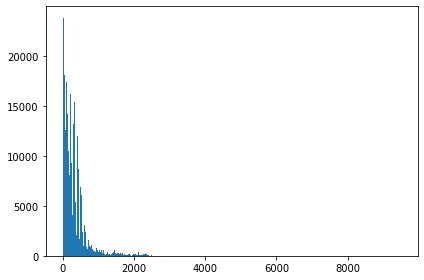

In [27]:
plt.hist(census_1880["house_number"], bins = 'auto')
plt.tight_layout()
plt.show()

In [28]:
#### Let's try a basic regression model
from sklearn.linear_model import LinearRegression

In [ ]:
#For now let's try representative wards as something to generalize this to

In [29]:
#select columns to use
print(census_1880.columns)
print(census_1850.columns)

Index(['OBJECTID.x', 'CENSUS_MERGEID', 'CENSUS_SERIALB', 'CENSUS_SERIAL',
       'CENSUS_PERNUM', 'CENSUS_RECIDUS', 'CENSUS_REEL', 'CENSUS_VOLUME',
       'CENSUS_PAGENUM', 'CENSUS_NAMEFRSTB', 'CENSUS_NAMELASTB',
       'CENSUS_RELATE', 'CENSUS_RELATE_STR', 'CENSUS_AGE', 'CENSUS_SEXB',
       'CENSUS_RACENAMEB', 'CENSUS_RACEB', 'CENSUS_NPERHHB',
       'CENSUS_OCCLABELB', 'CENSUS_SEIUSBN', 'CENSUS_MATCH_ADDR',
       'CENSUS_HOUSE_NUMB', 'CENSUS_STREETB', 'CENSUS_TYPEB',
       'CENSUS_SEGMENT_ID', 'CENSUS_BUILDING_I', 'CENSUS_NEIGHBOR_1',
       'CENSUS_NEIGHBOR_2', 'CENSUS_SEGGROUP_I', 'CENSUS_EXTGROUP_I',
       'CENSUS_CITY', 'CENSUS_COUNTYUS', 'CENSUS_X', 'CENSUS_Y',
       'CENSUS_ADDRESS', 'CENSUS_ENUMDIST', 'CENSUS_CITYNAME',
       'CENSUS_STATENAME', 'CENSUS_UNITTYPE', 'MERGE_SRC', 'WARD_NUM',
       'CENSUS_AD', 'house_number', 'street_name'],
      dtype='object')
Index(['CENSUS_SERIALP', 'CENSUS_AGE', 'CENSUS_SEX', 'CENSUS_MARST',
       'CENSUS_RACE', 'CENSUS_LABFORCE', '

In [ ]:
census_1880_model = census1880["CENSUS_AGE", "CENSUS_PAGENUM", "WARD_NUM", "CENSUS_RACEB", ""]

In [ ]:
wards = [3,9,10,18,21,22]
census_1880_train = census_1880[~census_1880["CENSUS_WARD_NUM"].isin(wards)]
census_1880_test